In [ ]:
# Here we aim to compute the numerical Epsilon-Delta curve with given cactus distribution
# Last Update: 12/09/2021 by Fei

Text(0.5, 1.0, 'PDFs, sen=1.0, var=1.00')

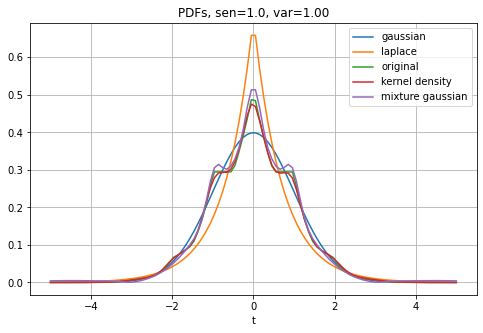

In [30]:
# Generate a kernel density estimator from samples

import numpy as np
import mpmath as mp
from scipy import signal
from scipy.stats import gaussian_kde
from scipy.stats import norm
import sklearn
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

# gaussian pdf
def gaussian_pdf(x,variance):
  return 1/np.sqrt(2*np.pi)/np.sqrt(variance)*np.exp(-x**2/2/variance)

# laplace pdf
def laplace_pdf(x, variance):
  b = np.sqrt(variance/2)
  return 1/2/b*np.exp(-np.abs(x)/b)

# the mixture gaussian pdf
def mixture_pdf(x,sen,variance, mixture_number):
  filename = ('privacy_data/mix_%d_d%.1f_v%.2f.csv' %(mixture_number, sen, variance))
  [mu_np,sigma_np,weights_np] = np.genfromtxt(filename, dtype=np.float32,delimiter=',')
  mu_np = mu_np.reshape((1,mixture_number))
  sigma_np = sigma_np.reshape((1,mixture_number))
  weights_np = weights_np.reshape((1,mixture_number))
  weights_np = weights_np/np.sum( weights_np)
  opt_pdf =np.matmul(1/np.sqrt(2*np.pi)/sigma_np*np.exp(-np.square(x-mu_np)/2/np.square(sigma_np)),np.transpose(weights_np))
  
  return np.abs(opt_pdf.reshape(-1))
  
  # the kernel density esimation of cactus
def kernel_pdf(x,sen,variance):
  filename = ('privacy_data/cactus_samples_d%1.1f_v%1.2f.npy' %(sen, variance))
  samples=np.load(filename)
  return gaussian_kde(samples).pdf(x)

# the original cactus pdf
def cactus_pdf(X,sen,variance):
  r=0.9
  filename = ('/home/fwei16/privacy_data/cactus_x_d%.1f_v%.2f.csv' %(sen,variance))
  x = np.genfromtxt(filename, dtype=np.float32)
  x = x.reshape(-1)
  xmax=max(x)
  n = len(x)/2//xmax

  filename = ('/home/fwei16/privacy_data/cactus_p_d%.1f_v%.2f.csv' %(sen,variance))
  p = np.genfromtxt(filename, dtype=np.float32)
  p = p.reshape(-1)    
    
  if np.abs(X)>=xmax:
    y=n*p[-1]*r**(n*(np.abs(X)-xmax))
  else:
    i = np.searchsorted(x,X)
    y = n*p[i]
#     y = n*p[i]+n**2*(p[i+1]-p[i])*(X-x[i])
  return y

sen = 1
variance = 1
mixture_number = 21

x=np.linspace(-5,5,100)
plt.figure(figsize=(8,5))
plt.plot(x,[gaussian_pdf(X,variance) for X in x],label='gaussian')
plt.plot(x,[laplace_pdf(X,variance) for X in x],label='laplace')
plt.plot(x,[cactus_pdf(X,sen,variance) for X in x],label='original')
plt.plot(x,[kernel_pdf(X,sen,variance) for X in x],label='kernel density')
plt.plot(x,[mixture_pdf(X,sen,variance,mixture_number) for X in x],label='mixture gaussian')
plt.grid(True)
plt.legend(loc='upper right')
plt.xlabel('t')
plt.title('PDFs, sen=%1.1f, var=%.2f' %(sen, variance))

In [36]:
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt
import scipy as sp

N = 1000
a = 0.01
q = 0.01
sen = 1
variance = 0.5
mixture_number = 21
pdf_list = [0,1,2] #0:gaussian 1:laplace 2:mixture 3:kernel 4:cactus
pdf_names = ['gaussian','laplace','mixuture','kernel','cactus']

def mu_sigma(f,logloss):
  itgr_lim = 10.0
  mu, mu_err  = sp.integrate.quad(lambda x: f(x)*logloss(x), -itgr_lim, itgr_lim) 
  sigma,sigma_err = np.sqrt(np.abs(sp.integrate.quad(lambda x: f(x)*np.power(logloss(x),2),-itgr_lim,itgr_lim)-np.power(mu,2)))
  return mu,sigma

def delta(a,eps,cf_func,mu,sigma,N):
  filter = lambda t: mp.sqrt(N*mp.power(sigma,2))*mp.exp(-(a+1j*t)*(eps-N*mu)/mp.sqrt(N)/sigma)/(a+1j*t)/(mp.sqrt(N)*sigma+a+1j*t)
  return mp.quad(lambda t: cf_func(t)*filter(t), [-mp.inf,mp.inf])/2/mp.pi

t_grid = np.linspace(0,5,10)
cf_list = [0]*5

for pdf_type in pdf_list:
  if pdf_type ==0:
    f = lambda x: gaussian_pdf(x,variance)
  if pdf_type ==1:
    f = lambda x: laplace_pdf(x,variance)
  if pdf_type ==2:
    f = lambda x: mixture_pdf(x,sen,variance,mixture_number)
  if pdf_type ==3:
    f = lambda x: kernel_pdf(x,sen,variance)
  if pdf_type ==4:
    f = lambda x: cactus_pdf(x,sen,variance)
  

  logloss = lambda x: np.log(f(x)/(q*f(x+sen)+(1-q)*f(x)))
  
  mu, sigma = mu_sigma(f,logloss)
  print("%s logloss mu is" %(pdf_names[pdf_type]), mu)
  print("%s logloss sigma is" %(pdf_names[pdf_type]), sigma)
  
  itgr_lim = 30.0
  
  cf_func = lambda t: np.power(sp.integrate.quad(lambda x: f(x)*np.exp((a+1j*t)*(logloss(x)-mu)/np.sqrt(N)/sigma), -itgr_lim, itgr_lim),N)
  cf_grid = [np.abs(cf_func(t)[0]) for t in t_grid]
  print("%s cf_grid is" %(pdf_names[pdf_type]), cf_grid)
  cf_list[pdf_type]=cf_grid
  


plt.figure(figsize=(8,5))
print(len(pdf_list))
for pdf_type in pdf_list:
  plt.semilogy(t_grid,cf_list[pdf_type],label=pdf_names[pdf_type])
plt.grid(True)
plt.legend(loc='upper right')
plt.xlabel('t')
plt.title('c.f., sen = %.1f, var = %.2f' %(sen, variance))

gaussian logloss mu is 0.0002588265688289429
gaussian logloss sigma is 0.021798299956849395


<ipython-input-36-ef9c03abec73>:41: RuntimeWarning: invalid value encountered in double_scalars
  logloss = lambda x: np.log(f(x)/(q*f(x+sen)+(1-q)*f(x)))
<ipython-input-36-ef9c03abec73>:41: RuntimeWarning: divide by zero encountered in log
  logloss = lambda x: np.log(f(x)/(q*f(x+sen)+(1-q)*f(x)))
<ipython-input-36-ef9c03abec73>:49: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  cf_func = lambda t: np.power(sp.integrate.quad(lambda x: f(x)*np.exp((a+1j*t)*(logloss(x)-mu)/np.sqrt(N)/sigma), -itgr_lim, itgr_lim),N)


gaussian cf_grid is [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
laplace logloss mu is 0.0001902529806212932
laplace logloss sigma is 0.019347053140639107
laplace cf_grid is [1.000051873677587, 0.8571634789595152, 0.5398762882177858, 0.2500506789426284, 0.085268448834235, 0.021444281110119753, 0.003986041944200904, 0.0005490814307624732, 5.622954723945555e-05, 4.296419861798307e-06]


<ipython-input-36-ef9c03abec73>:17: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  mu, mu_err  = sp.integrate.quad(lambda x: f(x)*logloss(x), -itgr_lim, itgr_lim)


mixuture logloss mu is 0.00022927088402854325
mixuture logloss sigma is 0.02082592225062567


TypeError: can't convert complex to float

In [25]:
eps_grid = np.linspace(0,2,5)
plt.figure(figsize=(8,5))
plt.semilogy(eps_grid,[np.abs(delta(a,eps,cf_func,mu,sigma,N)) for eps in t_grid],label='gaussian')
plt.grid(True)
plt.legend(loc='upper right')
plt.xlabel('epsilon')
plt.ylabel('delta')
plt.title('epsilon-delta, sen = %.1f, var = %.2f' %(sen, variance))

TypeError: loop of ufunc does not support argument 0 of type mpc which has no callable exp method

<Figure size 576x360 with 0 Axes>

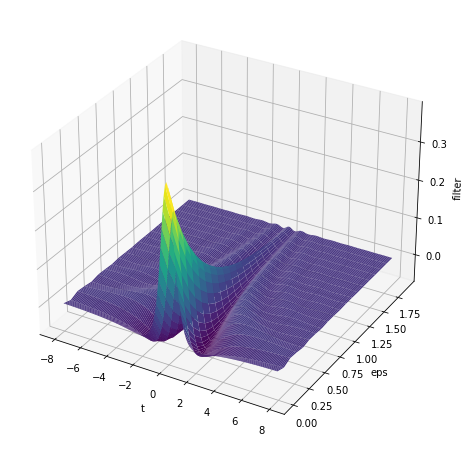

In [27]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

tt,ee = np.meshgrid(np.arange(-8,8,0.1),np.arange(0,2,0.1))

a=0.9
z_filter = np.sqrt(N* var_l)*np.exp(-(a+1j*tt)*(ee-N*mean_l)/np.sqrt(N*var_l))/(a+1j*tt)/(np.sqrt(N*var_l)+a+1j*tt)

fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(tt,ee,np.real(z_filter), rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_xlabel('t')
ax.set_ylabel('eps')
ax.set_zlabel('filter');